<a href="https://colab.research.google.com/github/mb1h0101/MB1H0101/blob/main/%E7%92%B0%E5%A2%83%E8%B3%87%E6%96%99%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92%E6%95%B4%E5%90%88_%E5%90%ABpH%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 環境資料深度學習整合 + pH 分析

包含：
- ✅ LSTM 時間序列預測 + 圖（pH, DO, 溫度）
- ✅ Autoencoder 異常偵測 + 圖
- ✅ 預測結果匯出 CSV
- ✅ pH 值時間變化與預測誤差分析

In [2]:
# 套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# 載入資料
df = pd.read_csv('/content/env_data.csv', encoding='big5')
df = df.fillna(df.mean(numeric_only=True))
df['時間'] = pd.to_datetime(df['日期'] + ' ' + df['小時'].astype(str) + ':00')
df.set_index('時間', inplace=True)
df.drop(columns=['日期', '小時'], inplace=True)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
def create_seq(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)
X, y = create_seq(scaled, 24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## 📈 原始資料：pH 時間變化

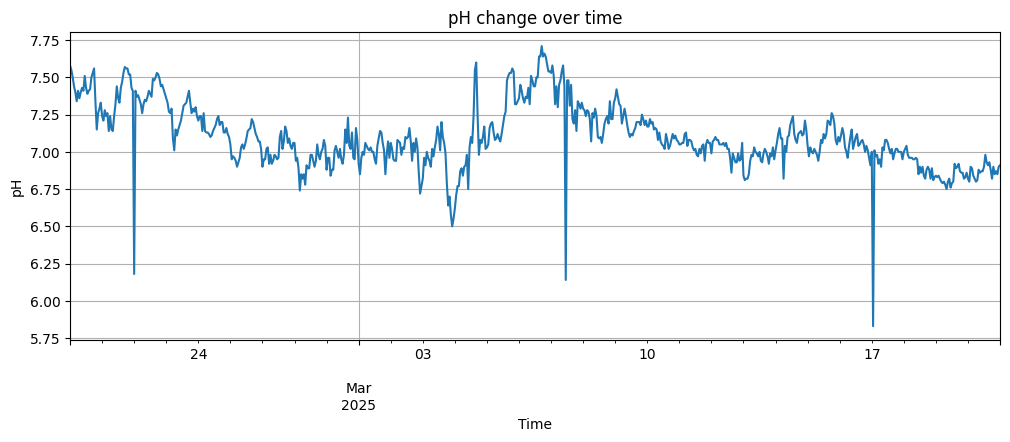

In [7]:

plt.figure(figsize=(12,4))
df['IM13570 - pH'].plot()
plt.title('pH change over time')
plt.xlabel('Time')
plt.ylabel('pH')
plt.grid(True)
plt.show()

## 🧠 LSTM 時間序列預測

In [8]:
model_lstm = Sequential([
    Input(shape=(24, X.shape[2])),
    LSTM(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X.shape[2])
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32,
              validation_split=0.2, callbacks=[EarlyStopping(patience=5)], verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.3701 - val_loss: 0.2750
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2145 - val_loss: 0.0876
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0482 - val_loss: 0.0390
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0269 - val_loss: 0.0238
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0200 - val_loss: 0.0254
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0177 - val_loss: 0.0240
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0146 - val_loss: 0.0231
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0108 - val_loss: 0.0206
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0112 - val_loss: 0.0202
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0093 - val_loss: 0.0191
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0098 - val_loss: 0.0187
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

### 📈 LSTM 預測圖（pH, DO, 溫度）

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


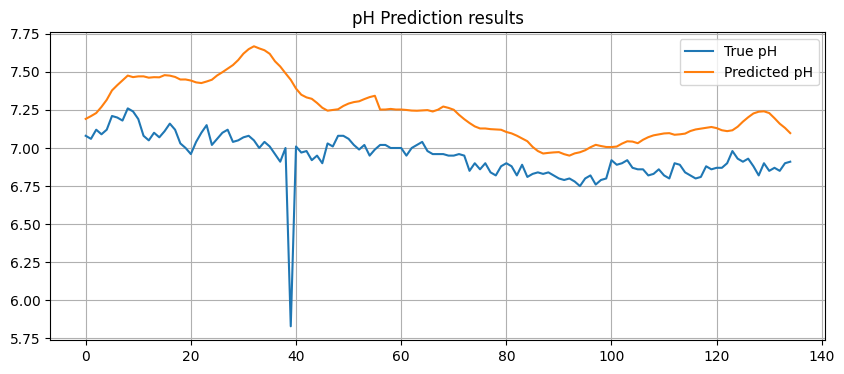

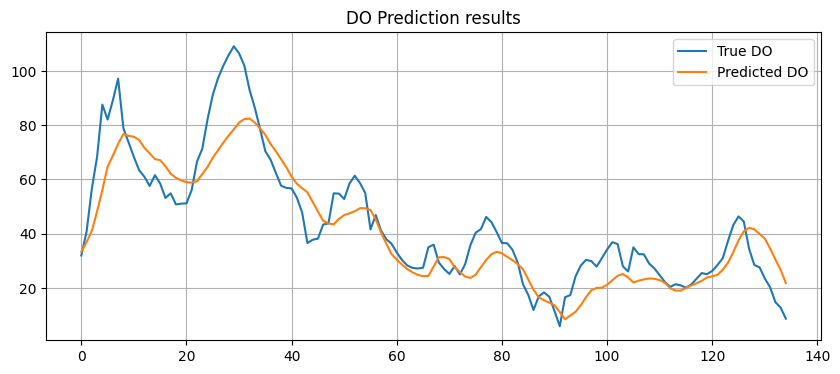

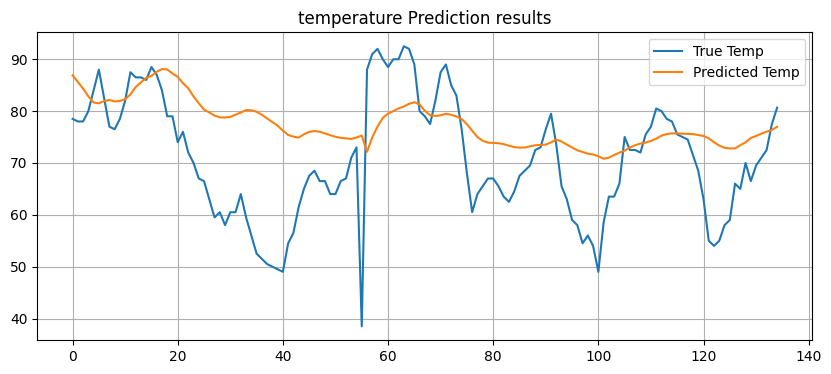

In [9]:
y_pred = model_lstm.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# pH
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:, 0], label='True pH')
plt.plot(y_pred_inv[:, 0], label='Predicted pH')
plt.legend(); plt.title('pH Prediction results'); plt.grid(True); plt.show()

# DO
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:, 2], label='True DO')
plt.plot(y_pred_inv[:, 2], label='Predicted DO')
plt.legend(); plt.title('DO Prediction results'); plt.grid(True); plt.show()

# 溫度
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:, 7], label='True Temp')
plt.plot(y_pred_inv[:, 7], label='Predicted Temp')
plt.legend(); plt.title('temperature Prediction results'); plt.grid(True); plt.show()

## 🔍 Autoencoder 異常分析

In [ ]:
inputs = Input(shape=(24, X.shape[2]))
encoded = LSTM(64, activation='relu')(inputs)
repeat = RepeatVector(24)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(repeat)
outputs = TimeDistributed(Dense(X.shape[2]))(decoded)
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32,
                validation_split=0.2, callbacks=[EarlyStopping(patience=5)], verbose=1)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.3226 - val_loss: 0.1187
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1019 - val_loss: 0.0599
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0545 - val_loss: 0.0522
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0425 - val_loss: 0.0377
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0321 - val_loss: 0.0339
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0235 - val_loss: 0.0322
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0184 - val_loss: 0.0273
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0145 - val_loss: 0.0260
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0125 - val_loss: 0.0214
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0119 - val_loss: 0.0195
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0103 - val_loss: 0.0198
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step


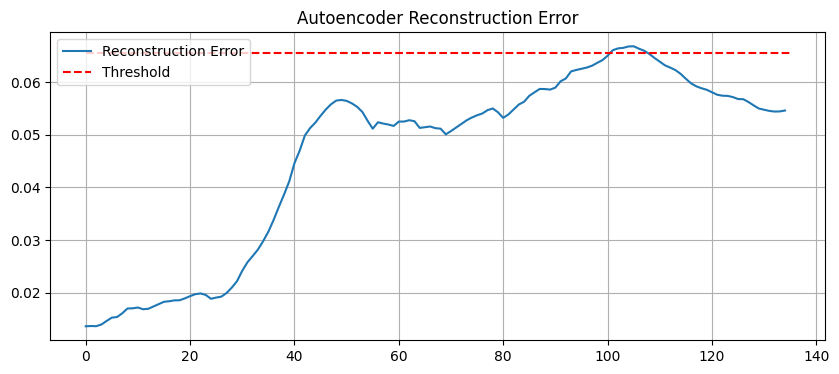

In [ ]:
# 異常偵測圖表
X_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))
threshold = np.percentile(mse, 95)
anomalies = mse > threshold
plt.figure(figsize=(10,4))
plt.plot(mse, label='Reconstruction Error')
plt.hlines(threshold, 0, len(mse), colors='r', linestyles='--', label='Threshold')
plt.legend(); plt.title('Autoencoder Reconstruction Error')
plt.grid(True); plt.show()

## 📋 預測結果匯出 CSV（pH, DO, 溫度）

In [ ]:
df_result = pd.DataFrame({
    'True_pH': y_test_inv[:, 0],
    'Predicted_pH': y_pred_inv[:, 0],
    'True_DO': y_test_inv[:, 2],
    'Predicted_DO': y_pred_inv[:, 2],
    'True_Temp': y_test_inv[:, 7],
    'Predicted_Temp': y_pred_inv[:, 7]
})
df_result.to_csv('/content/預測結果_含pH.csv', index=False)
df_result.head()

,True_pH,Predicted_pH,True_DO,Predicted_DO,True_Temp,Predicted_Temp
0,7.08,7.248789,32.0,29.300760,78.5,86.300461
1,7.06,7.250993,40.8,28.378351,78.0,86.718781
2,7.12,7.250977,56.6,27.331276,78.0,86.739212
3,7.09,7.266761,68.4,27.084976,80.0,86.842163
4,7.12,7.293097,87.6,27.469231,84.0,87.070526
